In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy.external as sce
import decoupler as dc
import scanorama

In [2]:
path_list = [r"C:\Users\thmet\Documents\outs 926983 hires", r"C:\Users\thmet\Documents\outs 926987 hires", r"C:\Users\thmet\Documents\outs 926991", r"C:\Users\thmet\Documents\outs 926895", r"C:\Users\thmet\Documents\outs 38032"]
names = ["926983", "926987", "926991", "926895", "38032"]
adatas = {}
for n, p in zip(names, path_list):
    adatas[n] = sc.read_visium(p)

C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are n

In [3]:
for n, adata in adatas.items():
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [4]:
path_list = [r"C:\Users\thmet\Documents\annotationsTMKS240416\Annotations_926983_240416.csv", r"C:\Users\thmet\Documents\annotationsTMKS240416\Annotations_926987_240416.csv", r"C:\Users\thmet\Documents\annotationsTMKS240416\Annotations_926991_240416.csv", r"C:\Users\thmet\Documents\annotationsTMKS240416\Annotations_926895_240416.csv", r"C:\Users\thmet\Documents\annotationsTMKS240416\Annotations_38032_240416.csv"]
names = ["926983", "926987", "926991", "926895", "38032"]
annos = {}
for n, p in zip(names, path_list):
    annos[n] = pd.read_csv(p)

In [5]:
anno_TM = {}
for n in names:
    anno_TM[n] = annos[n]["Annotations TM"]

In [6]:
for n, adata in adatas.items():
    adata.obs["anno_TM"]= pd.Categorical(anno_TM[n])

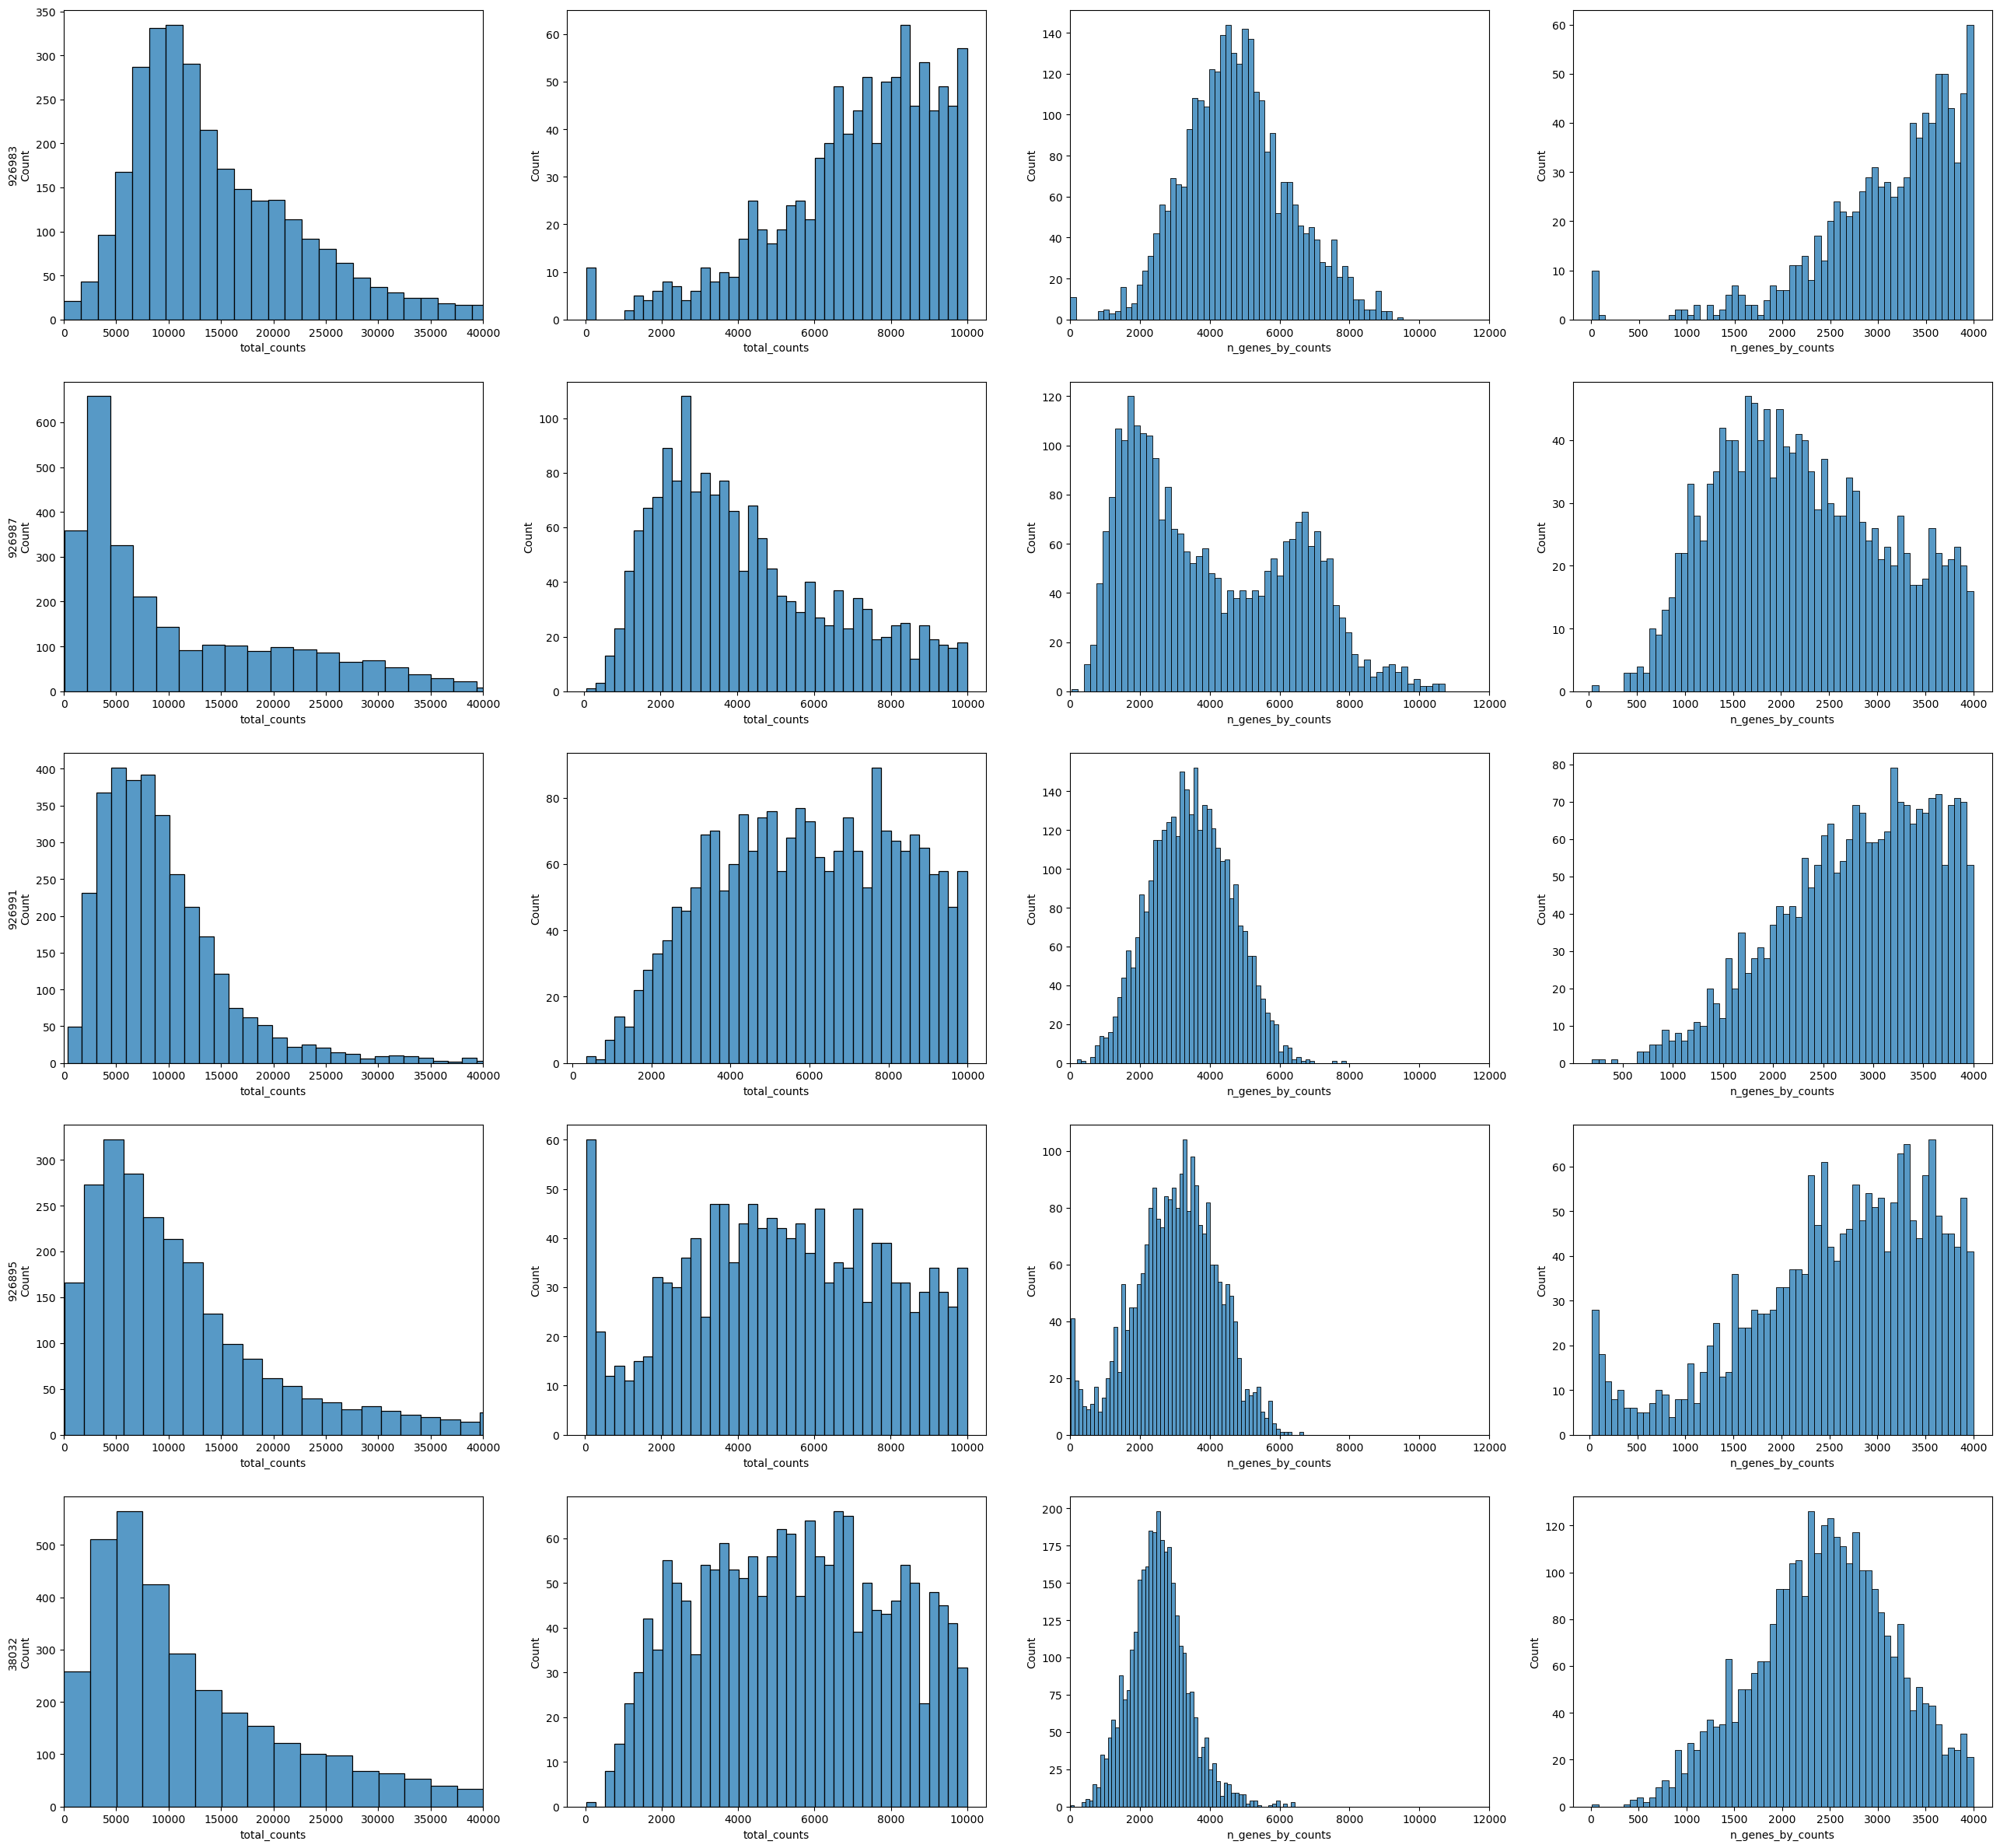

In [7]:
ncols = 4
nrows = len(adatas)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 6*nrows))

for i, (n, adata) in enumerate(adatas.items()):
    sns.histplot(adata.obs["total_counts"], kde=False, bins=40, ax=axs[i, 0])
    sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[i, 1])
    sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[i, 2])
    sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[i, 3])

    # add title
    axs[i, 0].set_ylabel(f"{n}\nCount")

    # set limits
    axs[i, 0].set_xlim(0, 40000)
    axs[i, 2].set_xlim(0, 12000)

plt.show()

In [8]:
for n, adata in adatas.items():
    sc.pp.filter_cells(adata, min_counts=2000)
    #sc.pp.filter_cells(adata, max_counts=40000)
    adata = adata[adata.obs["pct_counts_mt"] < 20]
    print(f"#cells after MT filter: {adata.n_obs}")
    sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2943


C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


#cells after MT filter: 2412


C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


#cells after MT filter: 3223


C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


#cells after MT filter: 2264


C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


#cells after MT filter: 3124


C:\Users\thmet\miniconda3\envs\thomas\Lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [9]:
adata_cc = sc.concat(adatas, label="dataset", uns_merge="unique", index_unique="-")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [10]:
adata_cc.layers["counts"] = adata_cc.X.copy()
sc.pp.normalize_total(adata_cc, inplace=True)
sc.pp.log1p(adata_cc)
adata_cc.layers["normalized"] = adata_cc.X.copy()
sc.pp.highly_variable_genes(adata_cc, flavor="seurat", n_top_genes=2000, batch_key="dataset")

In [11]:
sc.pp.pca(adata_cc)

In [12]:
sc.pp.neighbors(adata_cc)
sc.tl.umap(adata_cc)
sc.tl.leiden(adata_cc, key_added="clusters", resolution=0.8)



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




C:\Users\thmet\AppData\Local\Temp\ipykernel_11836\2594085616.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_cc, key_added="clusters", resolution=0.8)


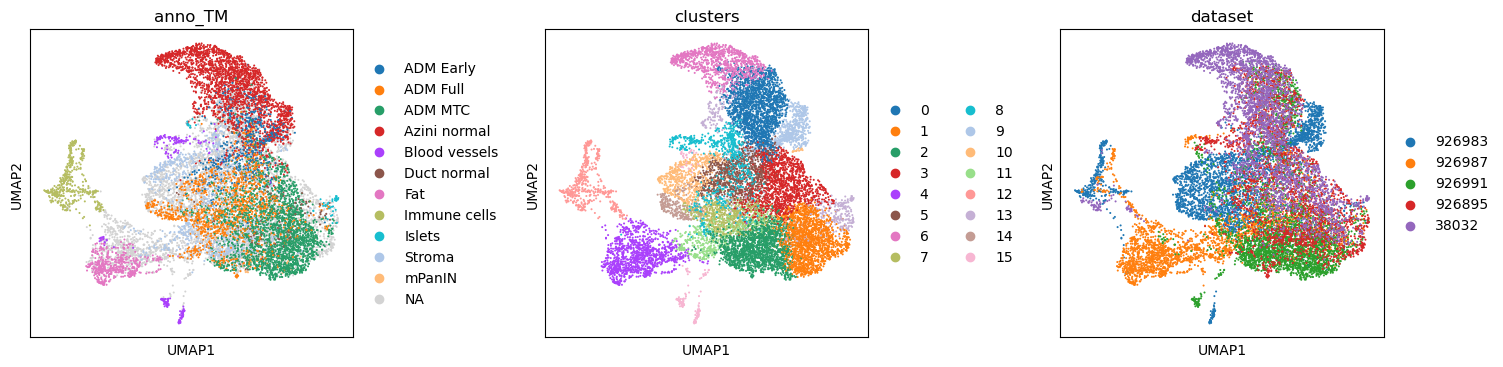

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_cc, color=["anno_TM", "clusters", "dataset"], wspace=0.45, save="umap_uncorrected_harm.pdf")

In [14]:
sce.pp.harmony_integrate(adata_cc, 'dataset')

2024-10-01 15:00:54,322 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-01 15:00:55,986 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-01 15:00:56,061 - harmonypy - INFO - Iteration 1 of 10
2024-10-01 15:00:59,697 - harmonypy - INFO - Iteration 2 of 10
2024-10-01 15:01:03,046 - harmonypy - INFO - Iteration 3 of 10
2024-10-01 15:01:06,220 - harmonypy - INFO - Iteration 4 of 10
2024-10-01 15:01:09,410 - harmonypy - INFO - Converged after 4 iterations


In [15]:
sc.pp.neighbors(adata_cc, use_rep="X_pca_harmony")
sc.tl.umap(adata_cc)
sc.tl.leiden(adata_cc, key_added="clusters", resolution=0.4) #resolution=0.78

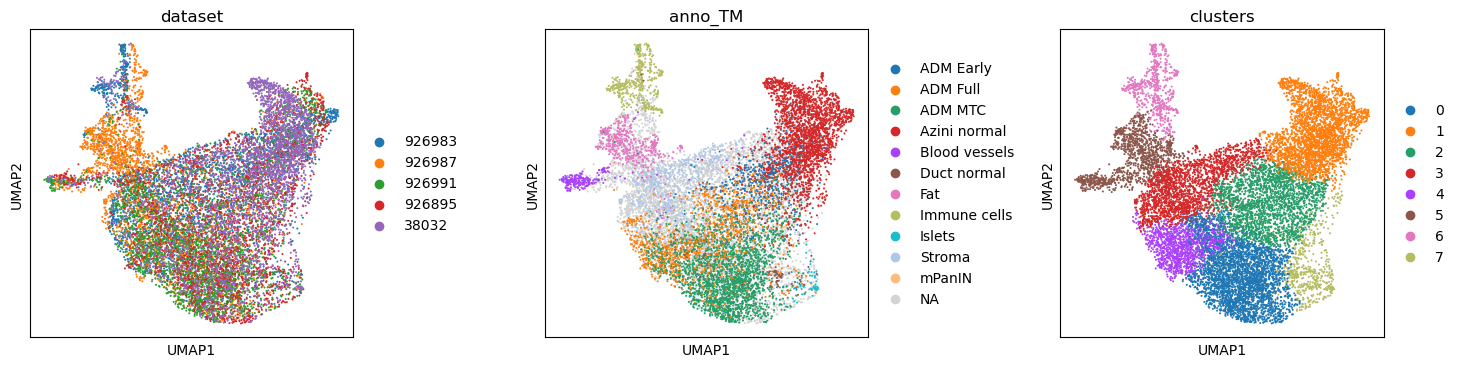

In [16]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_cc, color=["dataset", "anno_TM", "clusters"], wspace=0.45, save="umap_corrected_harm.pdf")

In [17]:
adata_cc.write("./results_harm.h5ad")

In [18]:
adata_cc.obs.to_csv("./results_clusters_anno_dataset_harm.csv", columns=["clusters", "anno_TM", "dataset"])

In [19]:
file = "./results_clusters_anno_dataset_harm.csv"

groupby = "anno_TM"
annotations = "clusters"

df = pd.read_csv(file, sep=",")
results = df.groupby(groupby)[annotations].value_counts(normalize=True, dropna=True) * 100
results = results[results > 5]
cumsum = results.groupby(level=groupby).cumsum()
index=cumsum.groupby(level=groupby).idxmax()
rest = 100 - cumsum.loc[index].reset_index(level=-1, drop=True)
rest=rest.reset_index()
rest.insert(1, "clusters", ["Rest", "Rest", "Rest", "Rest", "Rest", "Rest", "Rest", "Rest", "Rest", "Rest", "Rest"])
results=results.reset_index()
results=pd.concat([results, rest])
results = pd.DataFrame(results).reset_index()
results = results.pivot(columns=annotations, values="proportion", index=groupby)
custom_order = ['Azini normal', 'ADM Early', 'ADM Full', 'ADM MTC', "mPanIN", "Duct normal", "Islets", 'Stroma', 'Fat', 'Immune cells', 'Blood vessels',]
results = results.reindex(custom_order)
results

clusters,0,1,2,3,4,5,6,7,Rest
anno_TM,,,,,,,,,
Azini normal,NaN,88.869489,8.991707,NaN,NaN,NaN,NaN,NaN,2.138804
ADM Early,NaN,35.573770,57.049180,NaN,NaN,NaN,NaN,NaN,7.377049
ADM Full,18.721461,NaN,35.692542,NaN,36.301370,NaN,NaN,NaN,9.284627
ADM MTC,75.375774,NaN,12.113174,NaN,10.212202,NaN,NaN,NaN,2.298851
mPanIN,41.379310,NaN,34.482759,NaN,20.689655,NaN,NaN,NaN,3.448276
Duct normal,26.984127,NaN,12.698413,NaN,11.904762,NaN,NaN,42.063492,6.349206
Islets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.076923,1.923077
Stroma,13.617021,NaN,NaN,71.205674,NaN,NaN,NaN,NaN,15.177305
Fat,NaN,NaN,NaN,6.995885,NaN,92.592593,NaN,NaN,0.411523


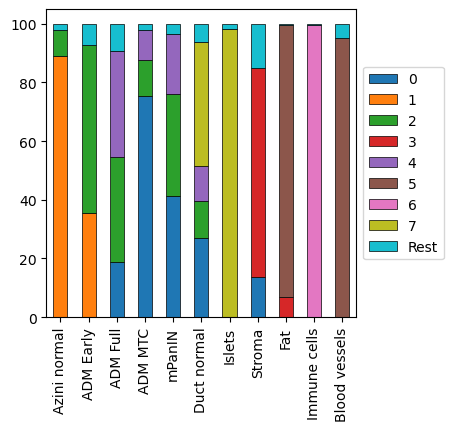

In [20]:
fig, ax = plt.subplots(1,1)
results.plot(kind="bar", stacked=True, ax=ax, edgecolor='black', linewidth=0.5, xlabel="", grid=False, color=([0.12156863, 0.46666667, 0.70588235, 1.        ],[1.         ,0.49803922 ,0.05490196 ,1.        ],[0.17254902, 0.62745098, 0.17254902, 1.        ],[0.83921569, 0.15294118, 0.15686275, 1.        ],[0.58039216, 0.40392157, 0.74117647, 1.        ],[0.54901961, 0.3372549 , 0.29411765, 1.        ] ,[0.89019608 ,0.46666667 ,0.76078431 ,1.        ],[0.7372549  ,0.74117647, 0.13333333 ,1.        ],[0.09019608, 0.74509804, 0.81176471, 1.        ],[0.68235294, 0.78039216, 0.90980392, 1.        ] ,[1.         ,0.73333333, 0.47058824 ,1.        ] ,[0.59607843, 0.8745098,  0.54117647, 1.        ], [1.        , 0.59607843, 0.58823529 ,1.        ],[0.77254902, 0.69019608, 0.83529412 ,1.        ] ,[0.76862745, 0.61176471, 0.58039216 ,1.        ],[0.96862745 ,0.71372549 ,0.82352941, 1.        ],[0.78039216 ,0.78039216 ,0.78039216 ,1.        ] ,[0.85882353, 0.85882353, 0.55294118, 1.        ], [0.61960784, 0.85490196 ,0.89803922 ,1.        ]))
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("./results_plot_harm.pdf", bbox_inches="tight")
plt.savefig("./results_plot_harm.tiff", bbox_inches="tight")
plt.show()

In [21]:
adata_cc926983 = adata_cc.obs[adata_cc.obs["dataset"] == "926983"]
adata_cc926983.index = adata_cc926983.index.str.replace('-926983', '')
adata_cc926983.to_csv("./cluster_harm_cloupe_926983.csv", columns=["clusters"])

In [22]:
adata_cc926987 = adata_cc.obs[adata_cc.obs["dataset"] == "926987"]
adata_cc926987.index = adata_cc926987.index.str.replace('-926987', '')
adata_cc926987.to_csv("./cluster_harm_cloupe_926987.csv", columns=["clusters"])

In [23]:
adata_cc926991 = adata_cc.obs[adata_cc.obs["dataset"] == "926991"]
adata_cc926991.index = adata_cc926991.index.str.replace('-926991', '')
adata_cc926991.to_csv("./cluster_harm_cloupe_926991.csv", columns=["clusters"])

In [24]:
adata_cc926895 = adata_cc.obs[adata_cc.obs["dataset"] == "926895"]
adata_cc926895.index = adata_cc926895.index.str.replace('-926895', '')
adata_cc926895.to_csv("./cluster_harm_cloupe_9268951.csv", columns=["clusters"])

In [25]:
adata_cc38032 = adata_cc.obs[adata_cc.obs["dataset"] == "38032"]
adata_cc38032.index = adata_cc38032.index.str.replace('-38032', '')
adata_cc38032.to_csv("./cluster_harm_cloupe_38032.csv", columns=["clusters"])